In [1]:
import json
from igraph import *
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

from pca_colors import breakpoints2intervals,sample_without_replacement
from analise_breakpoints import read_file
from analise_breakpoints import read_file_original

In [2]:
import colorsys

def get_colors_pallette(N):
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
    RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
    return RGB_tuples

In [3]:
source = 'wosPlosOne2016_citations.json'
text = open(source,'r').read()
data = json.loads(text)

In [34]:
data[16691]['DI']

'10.1371/journal.pone.0004185'

In [20]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def to_plot(map_by_color,filename):
    
    fig, ax = plt.subplots()
    
    
    keys = sorted(list(map_by_color.keys()))
    pallette = get_colors_pallette(len(keys))
    cmap = ListedColormap(pallette)
    
    for k,c in zip(keys,pallette):
        v = map_by_color[k]
        v = np.asarray(v)
        
        cov = np.cov(v, rowvar=False)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

        ellipse = Ellipse((mean(v[:,0]),mean(v[:,1])),
            width=np.std(v[:,0])*2,
            height=np.std(v[:,1])*2,angle=theta,fill=False,linewidth=2.0)
        
        ellipse.set_alpha(0.4)
        ellipse.set_edgecolor(c)
        ellipse.set_facecolor(None)
        ax.add_artist(ellipse)
        ax.scatter(v[:,0],v[:,1],color=c,alpha=0.05,label=k)

        #     plt.legend(bbox_to_anchor=(1, 1))
        #     plt.set_cmap(cmap)
    
    # plt.title(title+' original std='+ str(original_std[0])[:5]+' artificial std='+str(artificial_std[0])[:5])
    # plt.xlabel('original std ='+str(original_std[1])[:5]+' artificial std='+str(artificial_std[1])[:5])
    
    fig.suptitle(filename+' pca')
    fig.savefig(filename+'_num_authors_pca.png')
    plt.show()
    

def plot_pca_colors_num_authors(slopes,breakpoints,colors,k,filename):
    colors = np.asarray(colors)
    slopes = np.asarray([(np.arctan(s)*57.2958) for s in slopes])
    intervals = [breakpoints2intervals(b) for b in breakpoints]
    all_data = np.concatenate((slopes,intervals),axis=1)

    m = np.mean(all_data,axis=0)
    std = np.std(all_data,axis=0)
    all_data = (all_data - m)/std

    pca = PCA(n_components=2)
    pca.fit(all_data)

    y = pca.transform(all_data)

#     print(y.shape)
    if len(y) > 20000:
        idxs = sample_without_replacement(len(y),20000)
        y = y[idxs]
        colors = colors[idxs]
        
 
    map_by_color = defaultdict(lambda:[])
    for y_c,c in zip(y,colors):
        map_by_color[c].append(y_c)
    
    for k in map_by_color.keys():
        map_by_color[k] = np.asarray(map_by_color[k])
    
    to_plot(map_by_color,filename)

In [5]:
def plot_pca_colors_countries(slopes,breakpoints,colors,k,filename):
    colors = np.asarray(colors)
    slopes = np.asarray([(np.arctan(s)*57.2958) for s in slopes])
    intervals = [breakpoints2intervals(b) for b in breakpoints]
    all_data = np.concatenate((slopes,intervals),axis=1)

    m = np.mean(all_data,axis=0)
    std = np.std(all_data,axis=0)
    all_data = (all_data - m)/std

    pca = PCA(n_components=2)
    pca.fit(all_data)

    y = pca.transform(all_data)

#     print(y.shape)
    if len(y) > 20000:
        idxs = sample_without_replacement(len(y),20000)
        y = y[idxs]
        colors = colors[idxs]
    
    map_by_color = defaultdict(lambda:[])
    for y_c,c in zip(y,colors):
        map_by_color[c].append(y_c)
    
    plt.figure()
    
    cmap = cm.get_cmap('inferno', 10)
    
    for k,v in map_by_color.items():
        v = np.asarray(v)
        plt.scatter(v[:,0],v[:,1],cmap=cmap,alpha=0.3,label=k)
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(k)
    # plt.title(title+' original std='+ str(original_std[0])[:5]+' artificial std='+str(artificial_std[0])[:5])
    # plt.xlabel('original std ='+str(original_std[1])[:5]+' artificial std='+str(artificial_std[1])[:5])
    # plt.colorbar()
    plt.title(filename+' pca')
    plt.savefig(filename+'_origin_pca.png')
    plt.show()
    

In [25]:
def get_authors_origin(paper):
    authors_origin = []
    for origin in paper['C1'].split('; ['):
        origin = origin.split(', ')[-1]
        if 'USA' in origin:
            origin = 'USA'
        if origin == 'mac':
            origin = 'Macedonia'
        if origin == 'Antigua & Barbu':
            origin = 'W Ind Assoc St'
#         if origin == '*':
#             print(paper['C1'])
        if origin != '' and origin != '*':
            authors_origin.append(origin)
    return authors_origin

def map_color(map_dict,authors_origin):
    counter = Counter(authors_origin)
    if len(counter) > 0:
        return counter.most_common(1)[0][0]
    else:
        return 'Unknown'
    
def get_colors_countries(idxs,data):
    map_dict = dict()
    countries = []
    for idx in idxs:
        paper = data[idx]
        authors_origin = get_authors_origin(paper)
        color = map_color(map_dict,authors_origin)
        countries.append(color)
    unique,count = np.unique(countries,return_counts=True)
    rare = set()
    for u,c in zip(unique,count):
        if c < 50:
            rare.add(u)
    countries = ['Others' if c in rare else c for c in countries]
    return countries
# print(sorted(countries))

def get_color_num_authors(idxs,data):
    num_authors = []
    for idx in idxs:
        paper = data[idx]
        authors = paper['AF'].split(';')
        num_authors.append(len(authors))
    return num_authors

In [7]:
xs,ys = read_file_original(filename='data/plos_one_data_total.txt')

In [8]:
def filter_outliers(values):
    q75 = np.quantile(values,0.75)
    q25 = np.quantile(values,0.25)
    iqr = q75 - q25
    values = [min(q75+1.5*iqr,d) for d in values]
    values = [max(q25-1.5*iqr,d) for d in values]
    return values

2
(1274, 2)


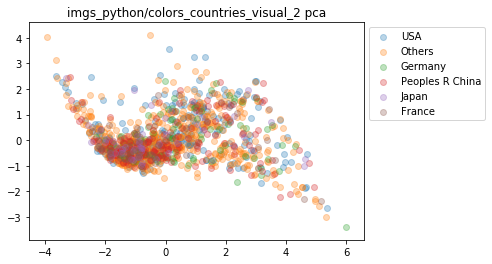

(1274, 2)


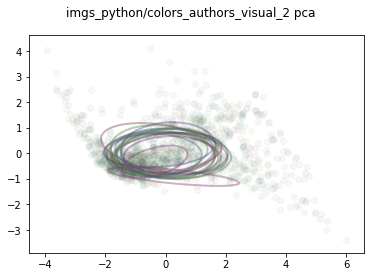

3
(11374, 2)


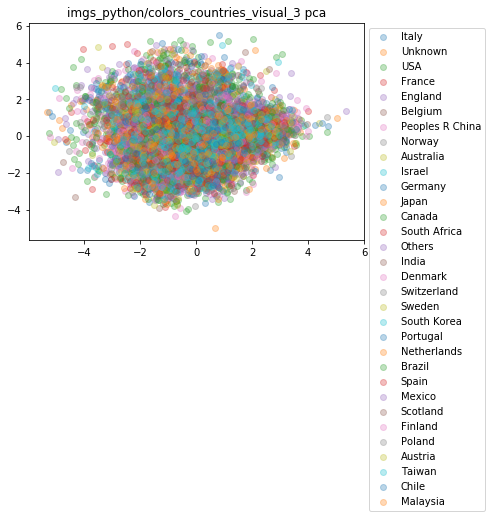

(11374, 2)


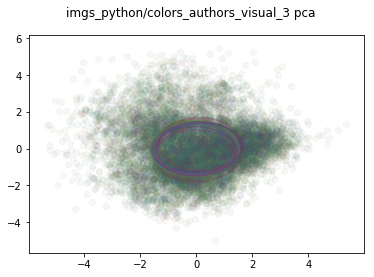

4
(41285, 2)


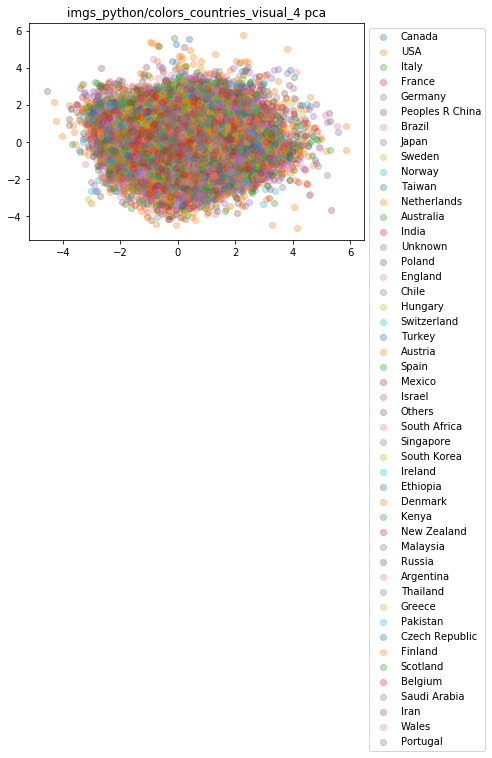

(41285, 2)


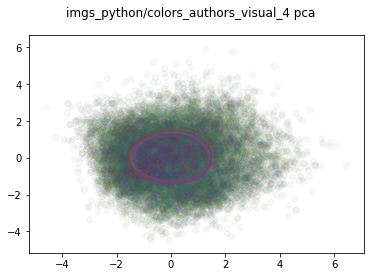

5
(70906, 2)


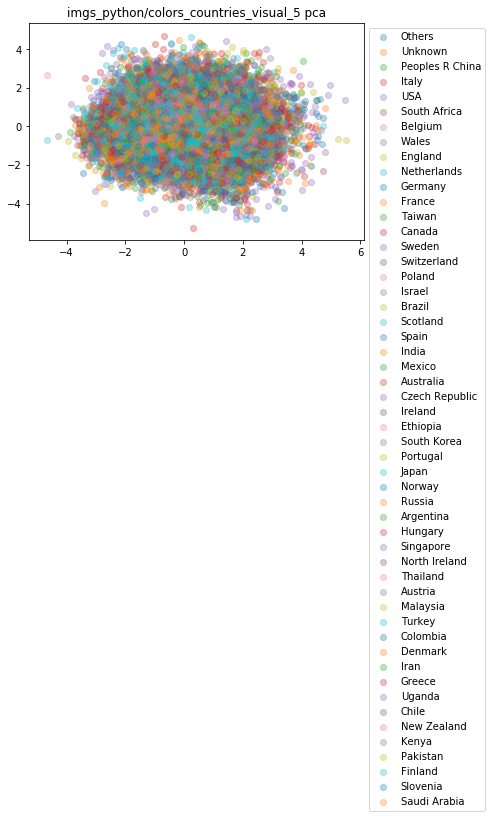

(70906, 2)


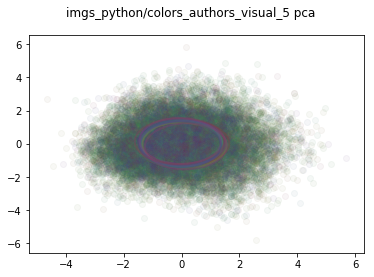

In [26]:
for n in [2,3,4,5]:
    print(n)
    idxs,slopes,breakpoints,_ = read_file(samples_breakpoints='data/plos_one_total_breakpoints_k4it.max100stop.if.errorFALSE_original_data_filtered.txt',n=n)

    #     xs_n = [xs[idx] for idx in idxs]
    
    countries = get_colors_countries(idxs,data)
    plot_pca_colors_countries(slopes,breakpoints,countries,n,'imgs_python/colors_countries_visual_'+str(n))
    
    num_authors = filter_outliers(get_color_num_authors(idxs,data))

    plot_pca_colors_num_authors(slopes,breakpoints,num_authors,n,'imgs_python/colors_authors_visual_'+str(n))